In [1]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
import numpy as np
import pandas as pd
import scanpy as sc
import h5py
import collections
import matplotlib.pyplot as plt
import scipy.sparse as sp_sparse
import seaborn as sb
from matplotlib import rcParams
from dca.api import dca
sc.set_figure_params(dpi=80, color_map='viridis')
sc.settings.verbosity = 2
sc.logging.print_versions()
results_file = './write/kw-note2-output.h5ad' 


/opt/conda/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),
Using TensorFlow backend.


scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


/opt/conda/lib/python3.7/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [2]:
adata = sc.read_10x_mtx(
    '/home/bd387/Work/SC/KW1/Data/NeuPro_aggr_mapped/outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)      
adata.shape

... reading from cache file cache/home-bd387-Work-SC-KW1-Data-NeuPro_aggr_mapped-outs-filtered_feature_bc_matrix-matrix.h5ad


(65153, 31053)

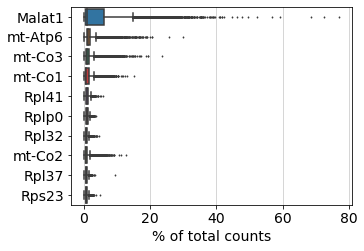

In [3]:
sc.pl.highest_expr_genes(adata, n_top=10)

In [4]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.shape

Trying to set attribute `.obs` of view, making a copy.


Total number of cells: 65153
Total number of genes: 31053


(65153, 31053)

... storing 'feature_types' as categorical


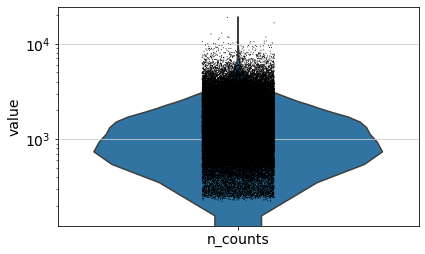

In [5]:
t1 = sc.pl.violin(adata, 'n_counts',  log=True)

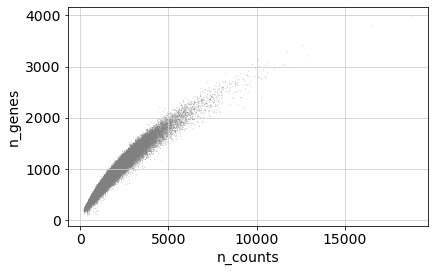

In [6]:
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes')

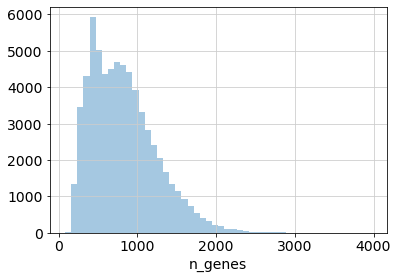

In [7]:
p3 = sb.distplot(adata.obs['n_genes'], kde=False)


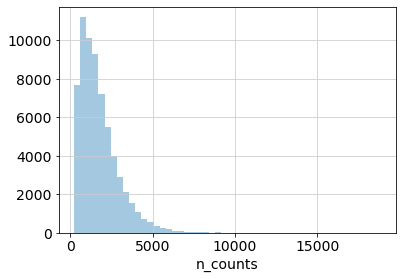

In [8]:
p3 = sb.distplot(adata.obs['n_counts'], kde=False)

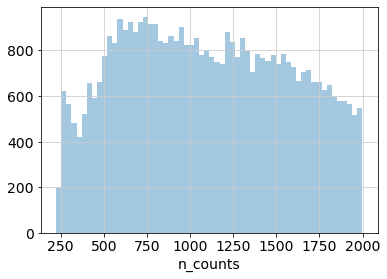

In [9]:
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<2000], kde=False, bins=60)

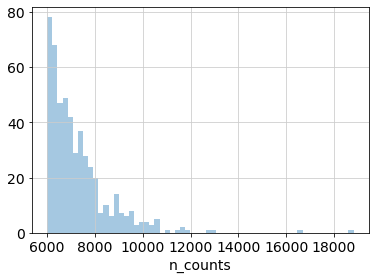

In [10]:
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>6000], kde=False, bins=60)

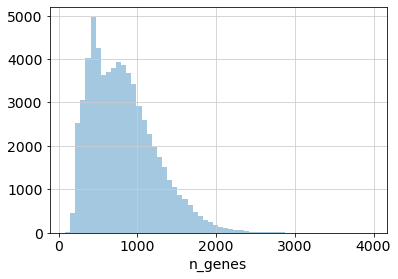

In [11]:
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

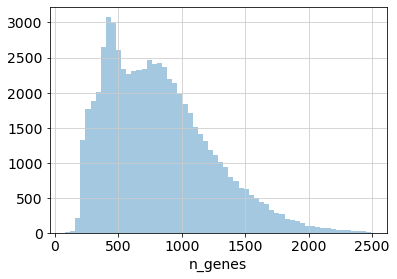

In [12]:
p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2500], kde=False, bins=60)
plt.show()


In [13]:
##### filter 200 genes, 500 counts, 60k counts
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 60000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))



Total number of cells: 65153
filtered out 4906 cells that have less than 500 counts
Number of cells after min count filter: 60247
Number of cells after max count filter: 60247
filtered out 19 cells that have less than 200 genes expressed
Number of cells after gene filter: 60228


In [14]:
adata.shape
#Find mito genes and filter them out
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
#Filter for mito
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata.shape

(60228, 31053)

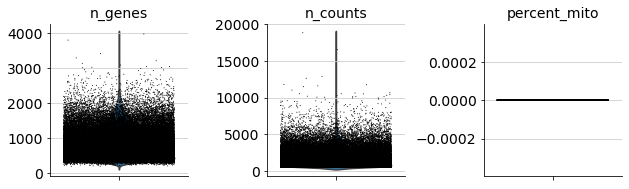

In [15]:
#Plots of quality measures
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)

In [16]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))
adata.shape

Total number of genes: 31053
filtered out 17501 genes that are detected in less than 20 cells
Number of genes after cell filter: 13552


(60228, 13552)

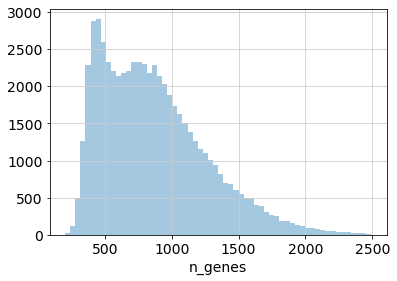

In [17]:
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2500], kde=False, bins=60)
plt.show()

#Check how denoising works

Lets keep a copy of the data and apply dca

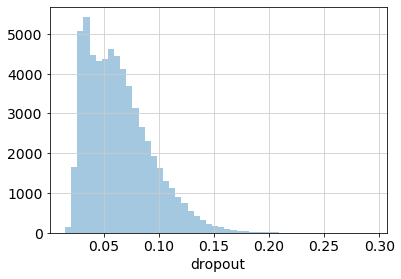

In [18]:
adata_raw = adata.copy()
adata_raw.obs['dropout'] = (adata_raw.X > 0).mean(1)
sb.distplot(adata_raw.obs['dropout'], kde=False)
plt.show()

In [19]:
#dca(adata, threads=1)
#sc.pp.normalize_per_cell(adata)
#sc.pp.log1p(adata)
#sc.pp.pca(adata)

In [20]:
#Calculate the difference in coefficient of variation after and before denoising per gene
#gene_cov_dn_diff = gene_cov_dn - gene_cov

In [21]:
#f1 = sb.distplot(gene_cov_dn_diff, kde=False)
#f1.set_yscale('log')
#f1.tick_params(labelsize=12)
#f1.set_xlabel('CoV change',fontsize=20)
#fig = f1.get_figure()
#fig.savefig('figures/klein_data_cov_change_denoising.png')
#plt.show()

In [22]:
sc.pp.normalize_total(adata, target_sum=1,key_added='n_counts2')

In [23]:
sc.pp.log1p(adata)
adata.raw = adata

If you pass `n_top_genes`, all cutoffs are ignored.


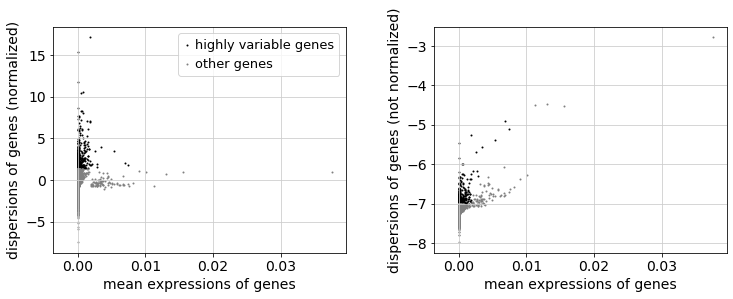

In [24]:
sc.pp.highly_variable_genes(adata, min_disp=0.3, n_top_genes=1000)
sc.pl.highly_variable_genes(adata)

In [25]:
adata = adata[:, adata.var['highly_variable']]

In [26]:
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=20)

In [27]:
#Principle component analysis
sc.tl.pca(adata, svd_solver='arpack')
#sc.tl.pca(adata)
#dir(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05.29)


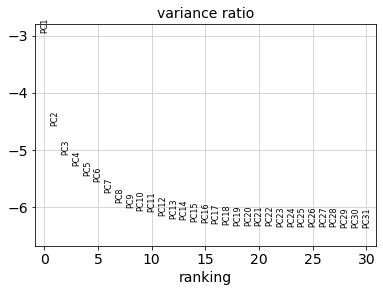

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
sc.pp.neighbors(adata)
sc.tl.louvain(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:21.03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:08.60)


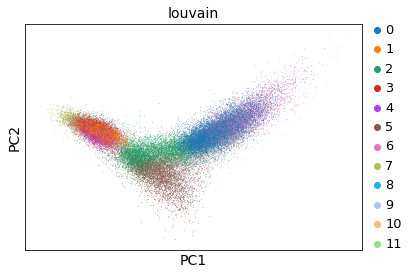

In [30]:
sc.pl.pca(adata, color='louvain')

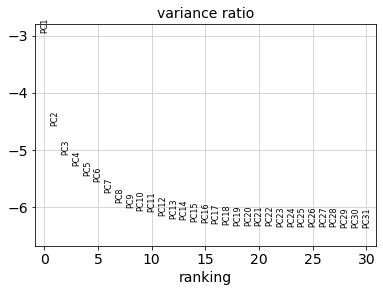

In [31]:
sc.pl.pca_variance_ratio(adata, log=True)

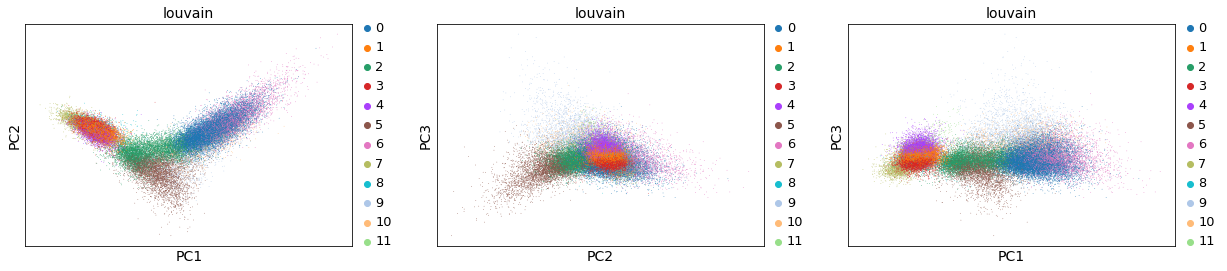

In [32]:
sc.pl.pca(adata, components=['1,2', '2,3', '1,3'], color='louvain')

In [33]:
sc.pp.neighbors(adata)
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:17.65)


computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:01:10.83)


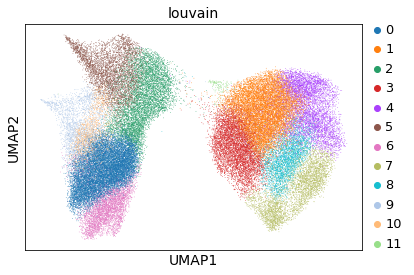

In [34]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain')

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:08:15.78)


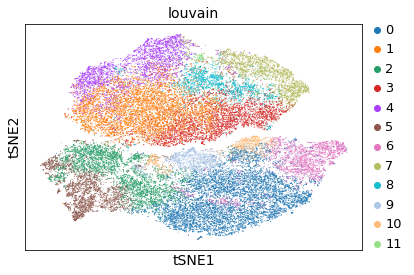

In [35]:
sc.tl.tsne(adata, n_pcs=10)
sc.pl.tsne(adata, color='louvain')

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.99770594 0.9806804  0.96852154 0.9632885  0.95668685
     0.9482497  0.93344283 0.92870665 0.9212593  0.9197564  0.91059047
     0.90588135 0.9041572  0.89974123]
    finished (0:00:02.04)


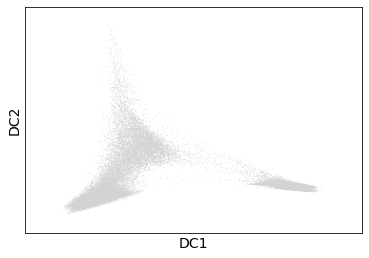

In [36]:
#sc.tl.tsne(adata, n_pcs=3)
sc.tl.diffmap(adata)
sc.pl.diffmap(adata)


In [37]:
#sc.tl.filter_rank_genes_groups(adata, min_fold_change=2)
#sc.tl.rank_genes_groups(adata, groupby= method='wilcoxon')
#sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')

In [38]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:09.28)


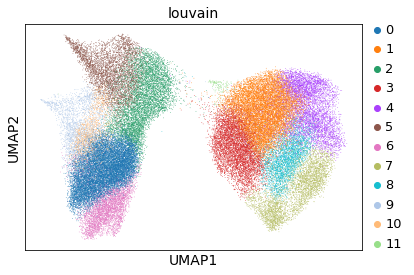

In [39]:
sc.pl.umap(adata, color=['louvain'])

ranking genes
    finished (0:00:17.76)


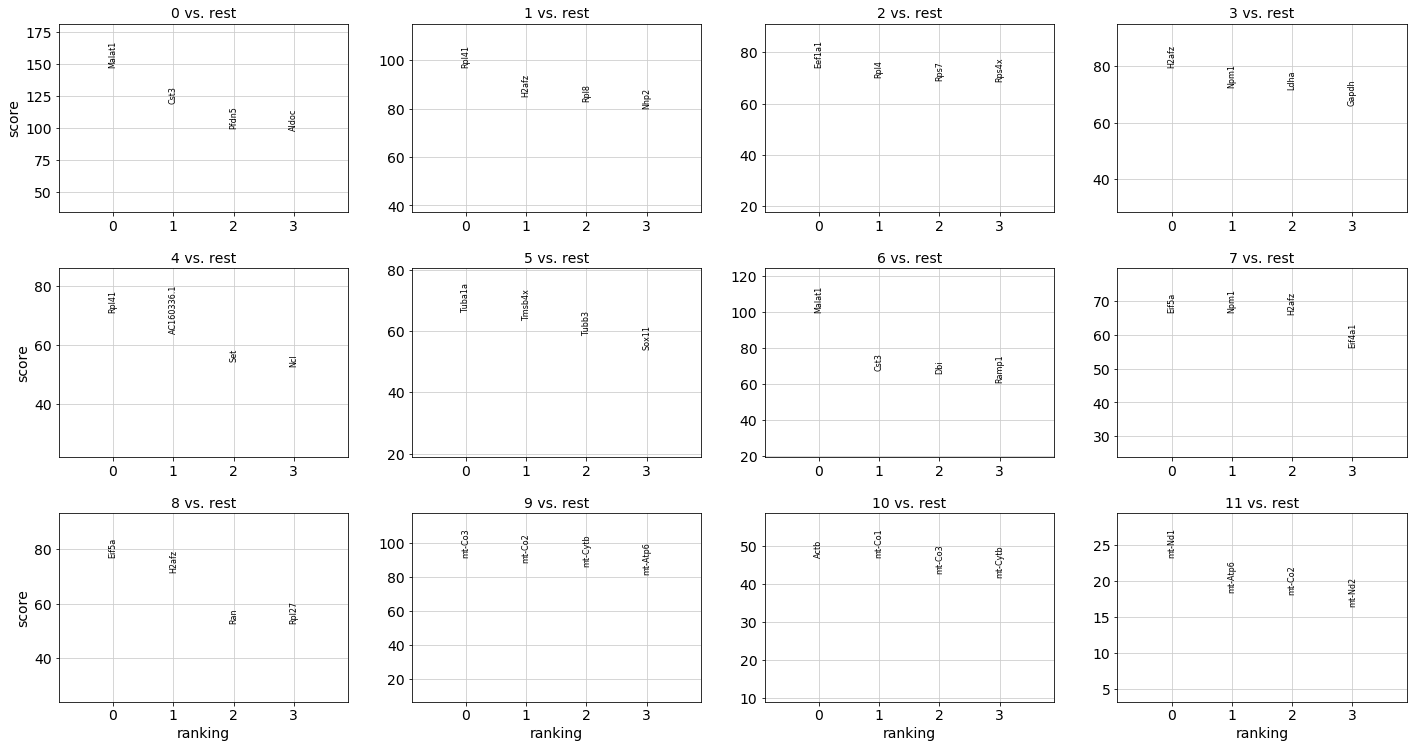

In [40]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=4, sharey=False)

ranking genes
    finished (0:01:09.30)


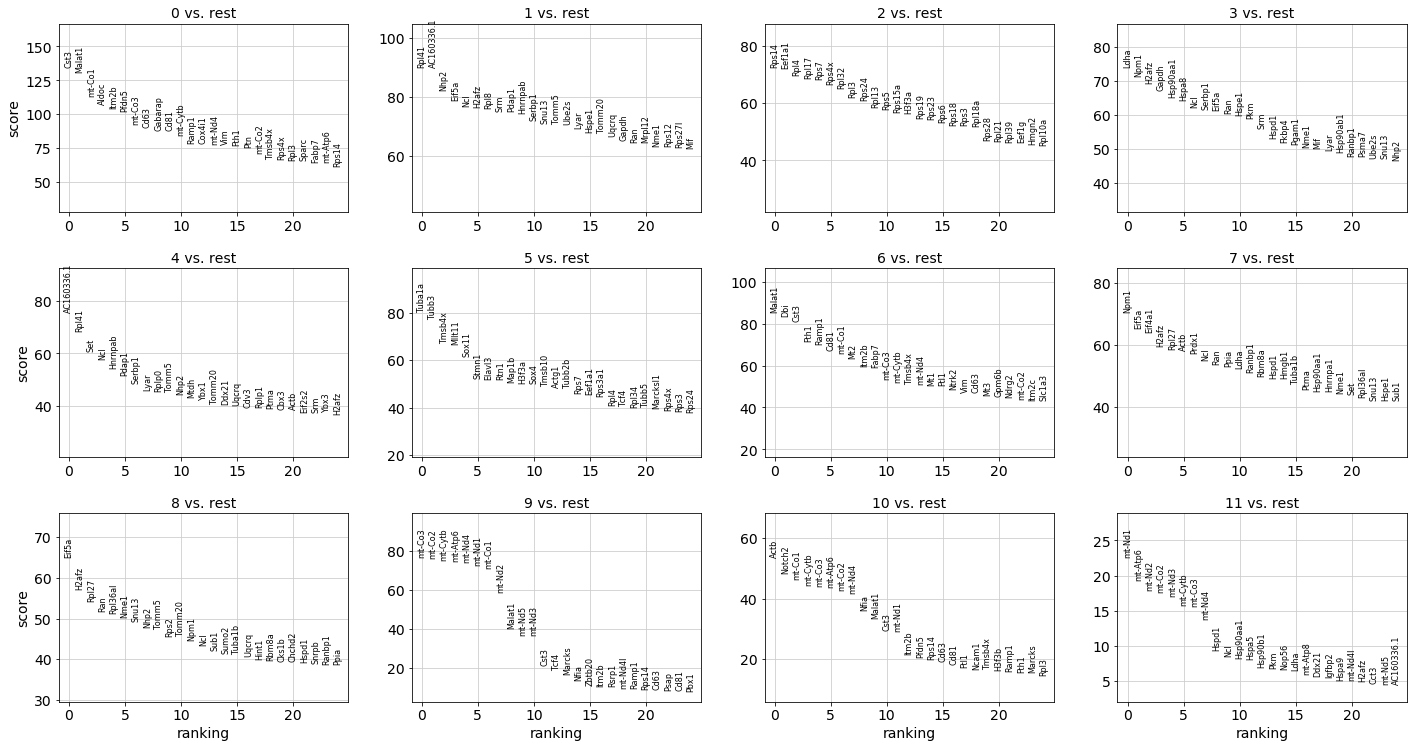

In [41]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:19.43)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:15.78)
running PAGA
    finished (0:00:02.14)
    number of colors in `.uns[louvain'_colors']` smaller than number of categories, falling back to palette


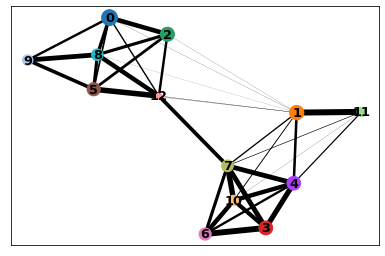

In [42]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
sc.tl.louvain(adata)
sc.tl.paga(adata)
sc.pl.paga(adata) 

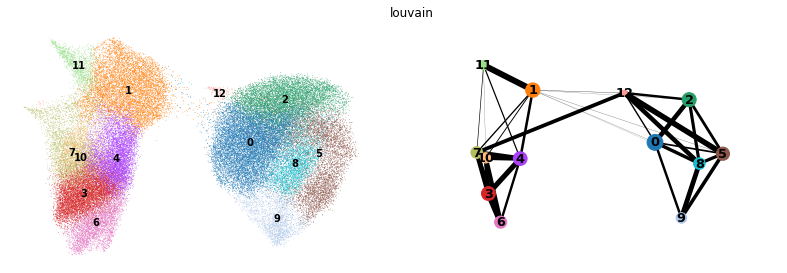

In [43]:
sc.pl.paga_compare(adata)